# Agricultural Drought Hazard Assessment

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [DROUGHTS](https://github.com/CLIMAAX/DROUGHTS) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

In this workflow we will assess the impact of water deficit on crop yields. 

The aim is to estimate the potential loss in yield for a given crop in the absence of an artificial irrigation system compensating for precipitation scarcity. This is particularly relevant for semi-arid regions which are increasingly prone to  prolonged drought periods making artificial irrigation unfeasible, as well as historically wet regions that have not yet implemented artificial irrigation at large-scale but might experience a significant decline in precipitation rates with future climate change. For more details, please refer to the [description](AGRICULTURE_Risk_workflow_description.md) document.

<figure class="align-center">
  <iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/xes91qOfoNQ?si=UUPhwTUSMF41CvoH" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>
</figure>

## Hazard Asssessment methodology

The starting point of the hazard assessment is the calculation of the soil standard evapotranspiration (ET0) using the Penman-Monteith equation described by FAO [(Allen et al., 1998)](https://www.fao.org/3/x0490e/x0490e00.htm). The Penman-Monteith equation allows to calculate the reference evapotranspiration demand (i.e., how much water does a standard plant requires to live) combining thermal radiation and wind data. ET0 does not hold any plant-specific information, but represents the climate-driven evapotranspiration demand for a reference crop. 

The standard evapotranspiration is then combined with a series of crop-specific information to derive the crop standard evapotranspiration (ETc). The crop-specific parameters used to calculate ETc vary depending on the [thermal climate zone](https://www.fao.org/publications/card/en/c/2b0a758c-d40d-5706-a80d-32ebd864a57a) considered. Thus, ETc represents the maximum evapotranspiration potential of each crop for a given thermal climate zone. From ETc, it is possible to derive the actual crop evapotranspiration (ETa) using precipitation data to estimate the local water availability for the plant. Hence, ETa represents a fraction of ETc. Using the equations from the FAO I&D 33 paper [(Doorenbos et al., 1979)](https://www.researchgate.net/publication/259842050_FAO_Irrigation_and_Drainage_Paper_33), is then possible to relate the ratio between the rainfed and the maximum evapotranspiration potential to the crop yield loss (%) in rainfed-only conditions.  

The hazard assessment can currently be performed for the 14 crops parameterised in the [crop table](crop_table.ipynb), but this can be modfied to add any crop the user might be interested in. The assessment is performed using climate data averaged inter-annually to show the impact of precipitation scarcity on yield for an average growing season in the selected period. 

### Limitations

One limitation of this approach to calculate yield losses derive from the parameterization of the crop-specific indicators. Indeed, the thermal climate zone division is rather coarse and does not allow to accurately capture all sub-regional climate characteristics. As a consequence, the definition of the season start and end days, as well as the length of the growing period might not accurately represent the real conditions in all studied regions. However, the user can overcome these limitations by manually edit the crop table csv file and insert the parameters that best represent the local conditions they want to assess.

Another limitation derives from the use of the Doorenbos et al., (1979) equation to relate water scarcity to yield losses. On one hand, this approach has been widely used in the literature as it is extremely straight-forward but still offers a good estimate of yield reductions. On the other, more sophisticated approaches have now been developed to get more accurate quantification of aridity-related yield losses taking into account additional processes and parameters [(Steduto et al., 2012)](https://www.fao.org/3/i2800e/i2800e00.htm). For the purpose of this workflow, the choice of the Doorenbos method seemed the most approapriate due to its long-standing solidity and computational efficiency. The user is invited to cross-check the results with those produced by more sophisticated softwares like [CropWat](https://www.fao.org/3/i2800e/i2800e.pdf) to assess the robustness of the workflow.

## Load libraries
In this notebook we will use the following Python libraries:

In [1]:
import glob
import json
import os
import re
import urllib
import zipfile

import cdsapi
import pooch

import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
import xarray as xr
import shapefile
import pyproj
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

:::{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown 
- [numpy](https://numpy.org/doc/stable/index.html) - To make calculations and handle data in the form of arrays.
- [pandas](https://pandas.pydata.org/docs/index.html) - To store data in the form of DataFrames.
- [geopandas](https://geopandas.org/en/stable/index.html) - To read georeferenced files as DataFrames.
- [zipfile](https://docs.python.org/3/library/zipfile.html) - To extract files from zipped folders.
- [os](https://docs.python.org/3/library/os.html) and [glob](https://docs.python.org/3/library/glob.html)- To create directories and work with files
- [pooch](https://www.fatiando.org/pooch/latest/index.html) and [urllib](https://docs.python.org/3/library/urllib.html) - To download data from various repositories.
- [cdsapi](https://pypi.org/project/cdsapi/) - To download data from the Copernicus Climate Data Storage. 
- [json](https://docs.python.org/3/library/json.html) - To read GeoJson files.
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - To access and explore geospatial raster data in GeoTIFF format.
- [xarray](https://docs.xarray.dev/en/stable/) - To access data in netCDF4 format.
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) and [pyproj](https://pyproj4.github.io/pyproj/stable/) - To reproject data between different coordinate systems.
- [matplotlib](https://matplotlib.org/) - For plotting.


## Create the directory structure
First, we need to set up the directory structure to make the workflow work.
The next cell will create the directory called 'agriculture_workflow' in the same directory where this notebook is saved. A directory for data and one for results will also be created inside the main workflow directory to store the downloaded data and the final plots. 

In [2]:
workflow_dir = 'agriculture_workflow'

# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_dir, 'data')
results_dir = os.path.join(workflow_dir, 'results')

# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_dir):
    os.makedirs(workflow_dir)
    os.makedirs(data_dir)
    os.makedirs(results_dir)

## Define the studied area

The cells below allow to download the boundaries of any NUTS2 region in the EU as a GeoJson file given the region code (in this case ES51 for Catalunya). You can look up the NUTS2 code for all EU regions [here](https://ec.europa.eu/eurostat/documents/3859598/15193590/KS-GQ-22-010-EN-N.pdf) by simply searching the document for the region name. 

The coordinates of the selected regions are extracted and saved in an array. Finally, the geometry of the GeoJson file is saved as a shapefile to be used in the plotting phase.

In [3]:
region = ['ES51'] #Replace the code in [''] with that of your region 

In [4]:
#auxiliary function to load region GeoJson file.
def load_nuts_json(json_path):
    # dependencies: json, urllib, geopandas, 
    while True:
        uh = urllib.request.urlopen(json_path)
        data = uh.read()
        break  
    gdf = gpd.GeoDataFrame.from_features(json.loads(data)["features"])
    gdf['Location'] = gdf['CNTR_CODE'] 
    gdf = gdf.set_index('Location')
    #gdf.to_crs(pyproj.CRS.from_epsg(4326), inplace=True)
    return gdf

# load nuts2 spatial data
json_nuts_path = 'https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_10M_2021_4326_LEVL_2.geojson'
nuts = load_nuts_json(json_nuts_path)
nuts = nuts.loc[nuts['NUTS_ID'].isin(region)]

#extract coordinates
df=gpd.GeoSeries.get_coordinates(nuts)
coords_user=df.to_numpy()

#save geometry as shapefile
nuts_name=re.sub(r'[^a-zA-Z0-9]','',str(nuts.iloc[0,4]))
nuts_shape=nuts.geometry.explode(index_parts=True).to_file(f'{data_dir}/{nuts_name}.shp')

The code below creates the study area bounding box using the coordinates of the region GeoJson file. The coordinates are then reprojected from the source projection to the climate data projection.

In some cases, it might be needed to expand the selected area through the 'scale' parameter to avoid the corners of the region being left out from the data extraction. The units of the 'scale' parameter are degrees, so setting scale=1 will increase the extraction area by approximately 100 km. A scale of 0-0.5 should be sufficient to fully cover most regions.  

:::{warning} The larger the scale parameter, the larger the extracted area, the longer the workflow will run for. Thus, the user is invited to have a first run of the workflow with scale=0.5, then increase it if not satisfied with the data coverage of the final map.

In [5]:
scale = 0.5

# Defining region bounding box
bbox = [
    np.min(coords_user[:,0])-scale,
    np.min(coords_user[:,1])-scale,
    np.max(coords_user[:,0])+scale,
    np.max(coords_user[:,1])+scale
]

## Download the climate datasets

Climate data is sourced from the [Copenicus Climate Data Store](https://cds.climate.copernicus.eu/datasets/projections-cordex-domains-single-levels?tab=overview). For this analysis, EURO-CORDEX climate projections for *precipitation flux, maximum temperature, minimum temperature, relative humidity, wind speed* and *solar downward radiation* at 12 km spatial resolution and *daily* temporal resolution have been employed. These projections are readily accessible to the public through the Climate Data Store (CDS) portal. The EURO-CORDEX data can be downloaded through the CDS API reported below.

For this example, we will guide you through downloading 5-year timeframes for each needed variable from the EURO-CORDEX repository. In this example the selected timeframe is 2046-2050 and the emission scenario is RCP2.6. We will also select a specific combination of General Circulation Model (GCM) and Regional Climate model (RCM). To download the data through the API below you will need to register an account on the Copernicus CDS. A complete guide on how to set up the API can be found [here](https://cds.climate.copernicus.eu/how-to-api). Once your API is set-up, **insert your own 'KEY'** below and run the cell to download the data. 

In the cell below, specify the starting and end year, as well as the RCP scenario of the period you are interested in. Climate data are stored in the CDS as separate 5 years simulations, so start and end years need to be specified for all of them. For simplicity, we suggest to run simulations for 2026-2046 (near future), 2036-2065 (mid-century), or 2071-2090 (end-of-century). Below, an example for the mid-century scenario is displayed. 

In [6]:
ystart=2046
yend=2050
rcp_download='rcp_2_6'
rcp='rcp26'

The cell below creates a list of start and end years based on your selection. These lists are needed to download the data since daily climate data from the CDS are stored as separate 5 years simulations. 

In [7]:
arr_start=np.arange(ystart,yend-4+1,5)
arr_end=np.arange(ystart+4,yend+1,5)
list_start=[str(x) for x in arr_start]
list_end=[str(x) for x in arr_end]

:::{warning} The download could take a few minutes (depending on your internet speed) due to the large dataset to download and the availability of the Copernicus repository. Once it starts, the status bar below the cell will keep you updated on the status of the download.

:::{important} Only some GCM-RCM combinations will allow you to download all the variables needed in this workflow. Extracting all the variables from the same GCM-RCM combination is important for data consistency. In this example we used **mpi_m_mpi_esm_lr** as the GCM and **smhi_rca4** as the RCM. The table below shows the 5 GCM-RCM combinations that allow to download all needed variables for all EURO-CORDEX emission scenarios (RCP2.6, RCP4.5 and RCP8.5). Although all climate projections are equally plausible, it is **recommended** to re-run the workflow using data from different models to test the results uncertainty.

|Number| Global Climate Model | Regional Climate Model |
| --- | --- | --- |
| 0 | ncc_noresm1_m | geric_remo2015 |
| 1 | mpi_m_mpi_esm_lr | smhi_rca4 |
| 2 | cnrm_cerfacs_cm5 | knmi_racmo22e |
| 3 | cnrm_cerfacs_cm5 | cnrm_aladin63 |
| 4 | ncc_noresm1_m | smhi_rca4 |

The cell below allows you to select which global-regional models combination you want to use for the assessment. To select the models, insert a number in the square brackets below using the same figure for both the global and regional lists. Numbering starts from 0, so we specified 1 to select mpi_m_mpi_esm_lr and smhi_rca4, which are the second elements in the respective lists. **N.B** Use the same number for both lists as the models are already paired. 

In [8]:
# List of model names for download and extraction
gcm_names = ['ncc_noresm1_m', 'mpi_m_mpi_esm_lr', 'cnrm_cerfacs_cm5', 'cnrm_cerfacs_cm5', 'ncc_noresm1_m']
rcm_names = ['gerics_remo2015', 'smhi_rca4', 'knmi_racmo22e', 'cnrm_aladin63', 'smhi_rca4']

gcm_extr_list = ['NCC-NorESM1-M', 'MPI-M-MPI-ESM-LR', 'CNRM-CERFACS-CNRM-CM5', 'CNRM-CERFACS-CNRM-CM5', 'NCC-NorESM1-M']
rcm_extr_list = ['GERICS-REMO2015', 'SMHI-RCA4', 'KNMI-RACMO22E','CNRM-ALADIN63', 'SMHI-RCA4']

# Select the global and regional climate model combination you
# want to use (note that Python starts counting at 0):
model_choice = 1

gcm = gcm_names[model_choice]
rcm = rcm_names[model_choice]
gcm_extr = gcm_extr_list[model_choice]
rcm_extr = rcm_extr_list[model_choice]

In [9]:
#Remove previously downloaded files for the same model and scenario
pattern = f'{data_dir}/EUR-11*{gcm_extr}*{rcp}*{rcm_extr}*day*.nc'
for file_path in glob.glob(pattern):
    if os.path.exists(file_path):
        os.remove(file_path)

#start new download
zip_path_cordex = os.path.join(data_dir, 'cordex_data '+gcm+'_'+rcm+'.zip')

URL = "https://cds.climate.copernicus.eu/api"
KEY = None # put your key here
c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'domain': 'europe',
        'experiment': rcp_download,
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'daily_mean',
        'variable': [
            '10m_wind_speed', '2m_relative_humidity', 'maximum_2m_temperature_in_the_last_24_hours',
            'mean_precipitation_flux', 'minimum_2m_temperature_in_the_last_24_hours', 'surface_solar_radiation_downwards'
        ],
        'gcm_model': gcm,
        'rcm_model': rcm,
        'ensemble_member': 'r1i1p1',
        'start_year': list_start,
        'end_year': list_end,
        'format': 'zip',
    },
    zip_path_cordex)

with zipfile.ZipFile(zip_path_cordex, 'r') as zObject:
    zObject.extractall(path=data_dir)

:::{tip}
You can download data for different emission scenarios, as well as start and end years by modifying the **experiment, start_year** and **end_year** parameters in the code above. 

### Explore the data
The downloaded files from CDS have a filename structure that describes the exact dataset contained. The general structure for daily files is the following:

   {variable}-{domain}-{gcm}-{rcp}-{ensemble}-{rcm}-{version}-day-{startyear}-{endyear}

Load one of the files and explore the content and structure of the dataset. Notice the dimensions, coordinates, data variables, indexes and attributes as well as the description of the spatial reference system in rotated_pole().


In [10]:
# Open one of the netCDF files as a dataset using xarray. Check your data folder (data_dir) to see
# which files were downloaded and insert a filename from there.
dataset_precipitation_example = xr.open_mfdataset(
    f'{data_dir}/pr_EUR-11_MPI-M-MPI-ESM-LR_rcp26_r1i1p1_SMHI-RCA4_v1a_day_20460101-20501231.nc',
    decode_coords='all'
)
# Display said dataset
dataset_precipitation_example

<xarray.Dataset> Size: 1GB
Dimensions:       (rlat: 412, rlon: 424, time: 1826, bnds: 2)
Coordinates:
    lat           (rlat, rlon) float64 1MB dask.array<chunksize=(412, 424), meta=np.ndarray>
    lon           (rlat, rlon) float64 1MB dask.array<chunksize=(412, 424), meta=np.ndarray>
  * rlat          (rlat) float64 3kB -23.38 -23.27 -23.16 ... 21.62 21.73 21.84
  * rlon          (rlon) float64 3kB -28.38 -28.27 -28.16 ... 17.94 18.05 18.16
    rotated_pole  |S1 1B ...
  * time          (time) datetime64[ns] 15kB 2046-01-01T12:00:00 ... 2050-12-...
    time_bnds     (time, bnds) datetime64[ns] 29kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    pr            (time, rlat, rlon) float32 1GB dask.array<chunksize=(1, 412, 424), meta=np.ndarray>
Attributes: (12/23)
    Conventions:                    CF-1.4
    contact:                        rossby.cordex@smhi.se
    creation_date:                  2017-02-17-T01:34:52Z
    experiment:                     RCP26
    experiment_id:                  rcp26
    driving_experiment:             MPI-M-MPI-ESM-LR, rcp26, r1i1p1
    ...                             ...
    rossby_run_id:                  201622
    rossby_grib_path:               /home/rossby/prod/201622/raw/
    rossby_comment:                 201622: CORDEX Europe 0.11 deg | RCA4 v1a...
    rcm_version_id:                 v1a
    c3s_disclaimer:                 This data has been produced in the contex...
    tracking_id:                    hdl:21.14103/3dcc2803-8bd0-4a29-b9e6-661c...

### Extract the climate data for the studied region

In the cell below the climate datasets are cut for the studied region. Data is also averaged so that the final datasets are composed of 365 values representing the inter-annual mean of the studied period. Thus, the assessment refers to a 'typical' annual growing season in the selected timeframe. 

In [11]:
def cut_to_region(ds, crs, bbox=bbox):
    '''Slice a dataset to a particular region'''
    transformer = pyproj.Transformer.from_crs('epsg:4326', crs)
    X_MIN, Y_MIN = transformer.transform(bbox[1], bbox[0])
    X_MAX, Y_MAX = transformer.transform(bbox[3], bbox[2])
    return ds.sel(y=slice(Y_MIN, Y_MAX), x=slice(X_MIN, X_MAX))

def open_and_cut(file_pattern, time_slice=None):
    '''Open files, cut to region and extract time slice'''
    ds = xr.open_mfdataset(file_pattern, decode_coords='all', chunks='auto')

    # Configure the coordinate reference system for the data
    if "rlat" in ds.coords and "rlon" in ds.coords:
        ds = ds.rename({'rlon': 'x', 'rlat': 'y'})
        # EURO-CORDEX rotated pole (used by most models)
        crs = ccrs.RotatedPole(
            pole_latitude=39.25,
            pole_longitude=-162
        )
    elif 'Lambert_Conformal' in ds.variables:
        # Make sure coordinates are given in m to match projection convention
        if ds.coords['x'].attrs['units'] == 'km':
            ds['x'] = 1000. * ds['x']
        if ds.coords['y'].attrs['units'] == 'km':
            ds['y'] = 1000. * ds['y']
        # Lambert conformal conic (used, e.g., by CNRM-ALADIN63)
        crs = ccrs.LambertConformal(
            central_longitude=ds['Lambert_Conformal'].attrs['longitude_of_central_meridian'],
            central_latitude=ds['Lambert_Conformal'].attrs['latitude_of_projection_origin'],
            standard_parallels=(ds['Lambert_Conformal'].attrs['standard_parallel'],),
            false_easting=0.5 * ds['x'].max().values,
            false_northing=0.5 * ds['y'].max().values
        )
    else:
        raise ValueError("Input data coordinates not supported")

    ds = cut_to_region(ds, crs)
    if time_slice is not None:
        ds = ds.sel({'time': time_slice})
    return ds

def doy_mean(ds):
    '''Compute day-of-year average'''
    return ds.convert_calendar('noleap').groupby('time.dayofyear').mean()

In [10]:
# The file patterns used below may match files that contain data from outside
# the specified time period. Therefore, cut to the specified period after
# loading to make sure the data that is loaded matches expectations. The default
# time period taken from the data download above. Adapt to your preferences:
time_slice = slice(str(ystart), str(yend))


# Extraction of each variable and averaging across years

# Tmax
ds_tasmax = open_and_cut(f'{data_dir}/tasmax_EUR-11*{gcm_extr}*{rcp}*{rcm_extr}*day*.nc', time_slice)
Tmax = doy_mean(ds_tasmax['tasmax']).to_numpy()-273.15

# Tmin
ds_tasmin = open_and_cut(f'{data_dir}/tasmin_EUR-11*{gcm_extr}*{rcp}*{rcm_extr}*day*.nc', time_slice)
Tmin = doy_mean(ds_tasmin['tasmin']).to_numpy()-273.15

# Tmean
Tmean=(Tmax-Tmin)/2

# Precipitation
ds_precipitation = open_and_cut(f'{data_dir}/pr_EUR-11*{gcm_extr}*{rcp}*{rcm_extr}*day*.nc', time_slice)
precipitation = doy_mean(ds_precipitation['pr']).to_numpy()*86400  # conversion from kg/m2/s to mm/day

# Wind speed
ds_ws = open_and_cut(f'{data_dir}/sfcWind_EUR-11*{gcm_extr}*{rcp}*{rcm_extr}*day*.nc', time_slice)
ws = doy_mean(ds_ws['sfcWind']).to_numpy()*(4.87/np.log(67.8*10-5.42))  # conversion from 10m wind speed to 2m wind speed
ws[ws<0] = 0

# Relative humidity
ds_hurs = open_and_cut(f'{data_dir}/hurs_EUR-11*{gcm_extr}*{rcp}*{rcm_extr}*day*.nc', time_slice)
relhum = doy_mean(ds_hurs['hurs']).to_numpy()

# Solar downward surface radiation
ds_rsds = open_and_cut(f'{data_dir}/rsds_EUR-11*{gcm_extr}*{rcp}*{rcm_extr}*day*.nc', time_slice)
rad = doy_mean(ds_rsds['rsds']).to_numpy()*0.0864  # conversion from Watts to MegaJoules

## Download the Available Water Capacity, Elevation and Thermal Climate Zones datasets

To calculate the crop evapotranspiration potential (ETc) we need information about the local Available Water Capacity, elevation and thermal climate zone. The cells below show how to download these datasets and extract information for the studied region.

### 1. Available Water Capacity

The available water capacity (AWC) represents the maximum amount of water the soil can store within a certain depth. In this workflow we are using data for soil depths of 0-200 cm. The data are sourced from [Hengl and Gupta (2019)](https://zenodo.org/records/2629149) and represent the 1950-2017 historical average. The cell below downloads the data as a .tif file (~5 GB size) from the zenodo repository and saves it in the data directory.

In [12]:
url = 'doi:10.5281/zenodo.2629149/sol_available.water.capacity_usda.mm_m_250m_0..200cm_1950..2017_v0.1.tif'
filename = 'sol_available.water.capacity_usda.mm_m_250m_0..200cm_1950..2017_v0.1.tif'

pooch.retrieve(
    url=url,known_hash='md5:07129d7ed5e7d1457677bdedee926b27',fname=filename,
    path=data_dir,downloader=pooch.DOIDownloader())

### 2. Elevation

Elevation data are sourced from the USGS GDTEM 2010 digital elevation model [(Danielson & Gesch, 2011)](https://pubs.usgs.gov/of/2011/1073/). This dataset has relatively coarse resolution compared to more recent DEM, but it is adequate for the resolution of this assessment. The cell below downloads the DEM at 30 arc-second resolution as a .zip folder, then extracts it in the data directory. 

In [13]:
url = 'https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/topo/downloads/GMTED/Grid_ZipFiles/mn30_grd.zip'
filename = 'mn30_grd.zip'
pooch.retrieve(
    url=url,fname=filename,
    known_hash=None,
    path=data_dir)
with zipfile.ZipFile(f'{data_dir}/mn30_grd.zip', 'r') as zObject:
    zObject.extractall(path=data_dir)

### 3. Thermal Climate Zones

The thermal climate zones represent a classification of global climates in 8 categories characterised by different annual temperature ranges and rain seasons [(Van Velthuizen et al., 2007)](https://www.fao.org/publications/card/en/c/2b0a758c-d40d-5706-a80d-32ebd864a57a). This classification is helpful for agricultural modelling as crops have different growing calendars and evapotranspirative responses depending on the temperature/precipitation regime. 
The cell below downloads the thermal climate zones raster from the FAO repository as a .zip folder and extracts it in the data directory. 

In [14]:
url = 'https://storage.googleapis.com/fao-maps-catalog-data/uuid/68790fd0-690c-11db-a5a5-000d939bc5d8/resources/Map4_1.zip'
filename = 'Map4_1.zip'
pooch.retrieve(
    url=url,fname=filename,
    known_hash=None,
    path=data_dir)

with zipfile.ZipFile(f'{data_dir}/Map4_1.zip', 'r') as zObject:
    zObject.extractall(path=data_dir)

### Extract the AWC, elevation and thermal climate zones data for the studied region

In [15]:
# Select the lon and lat coordinates from one of the climate datasets extracted before and create an array of points
coords_11 = np.hstack([
    ds_tasmax['lon'].to_numpy().reshape((-1, 1)),
    ds_tasmax['lat'].to_numpy().reshape((-1, 1))
])
raster_shape = (Tmax.shape[1], Tmax.shape[2])

# Empty dataframe to store extracted data temporarily
dff = pd.DataFrame() 

# Sample each raster file at the coordinates found above and save the data

# AWC
raster_path = f'{data_dir}/sol_available.water.capacity_usda.mm_m_250m_0..200cm_1950..2017_v0.1.tif'
with rasterio.open(raster_path) as src:
    dff['AWC'] = [x[0] for x in src.sample(coords_11)]  
AWC = dff['AWC'].to_numpy(dtype='float64').reshape(raster_shape)
AWC[AWC < 0] = 0

# Elevation
raster_path = f'{data_dir}/mn30_grd/w001001.adf'
with rasterio.open(raster_path) as src:
    dff['elev'] = [x[0] for x in src.sample(coords_11)]    
elev = dff['elev'].to_numpy(dtype='float64').reshape(raster_shape)

# Climate zones
raster_path = f'{data_dir}/therm_clim/w001001.adf'
with rasterio.open(raster_path) as src:
    dff['clim'] = [x[0] for x in src.sample(coords_11)]

# Determine most common value as replacement value for climate zone errors
dff.loc[dff['clim'] < 0, 'clim'] = np.nan
dff_clim_mode = dff['clim'].mode(dropna=True)
assert not dff_clim_mode.empty

climate_zone = (
    dff['clim']
    .fillna(dff_clim_mode[0])
    .to_numpy(dtype='float64')
    .reshape(raster_shape)
)

### Explore the data
Now that we have extracted the data, you can simply call the AWC, elev and climate_zone variables to visualise them. All variables are stored as a [numpy array](https://numpy.org/doc/stable/user/absolute_beginners.html) and have the same shape (i.e., lon x lat dimension) of the climate datasets.
<br>
To see the shape of the extracted files:

In [16]:
elev.shape 

(24, 34)

This tells us that in this case, the extracted area for Catalunya is formed by a lon-lat grid of 24x34 12.5 km pixels.

## Import crop-specific information

Crop specific paramters needed for the hazard assessment are imported from the [crop table](crop_table.csv). The cell below reads the crop table file and prints it.

:::{tip} A complete description of the crop table is available [here](crop_table.ipynb).

In [17]:
crop_table=pd.read_csv('crop_table.csv')
crop_table

,FAO_Code,Crop,Clim,Kc_in,Kc_mid,Kc_end,lgp_f1,lgp_f2,lgp_f3,lgp_f4,Season start,Season End,RD1,RD2,DF,Type,Ky
0,111,wheat,2,0.7,1.15,0.30,0.125000,0.208333,0.416667,0.250000,135.0,255,0.2,1.25,0.55,1,1.0
1,111,wheat,3,0.7,1.15,0.30,0.111111,0.333333,0.388889,0.166667,319.0,134,0.2,1.25,0.55,1,1.0
2,111,wheat,4,0.7,1.15,0.30,0.477612,0.223881,0.223881,0.074627,289.0,259,0.2,1.25,0.55,1,1.0
3,111,wheat,5,0.7,1.15,0.30,0.111111,0.333333,0.388889,0.166667,336.0,151,0.2,1.25,0.55,1,1.0
4,111,wheat,7,0.4,1.15,0.30,0.477612,0.223881,0.223881,0.074627,320.0,290,0.2,1.25,0.55,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,122,sweet_potato,3,0.5,1.15,0.65,0.133333,0.200000,0.400000,0.266667,91.0,241,0.2,1.25,0.65,1,1.0
80,122,sweet_potato,4,0.5,1.15,0.65,0.133333,0.200000,0.400000,0.266667,121.0,271,0.2,1.25,0.65,1,1.0
81,122,sweet_potato,5,0.5,1.15,0.65,0.133333,0.200000,0.400000,0.266667,121.0,271,0.2,1.25,0.65,1,1.0
82,122,sweet_potato,7,0.5,1.15,0.65,0.133333,0.200000,0.400000,0.266667,121.0,271,0.2,1.25,0.65,1,1.0


The resulting table is a [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) that you can explore using the column keys. For instance, to check information for all available crops in the temperate oceanic climate zone you can use: 

In [18]:
crop_table[(crop_table["Clim"] == 4)]

,FAO_Code,Crop,Clim,Kc_in,Kc_mid,Kc_end,lgp_f1,lgp_f2,lgp_f3,lgp_f4,Season start,Season End,RD1,RD2,DF,Type,Ky
2,111,wheat,4,0.70,1.15,0.30,0.477612,0.223881,0.223881,0.074627,289.0,259,0.2,1.25,0.55,1,1.00
8,113,maize,4,0.30,1.20,0.50,0.200000,0.200000,0.266667,0.333333,106.0,256,0.2,1.00,0.55,1,1.50
14,112,rice,4,1.05,1.20,0.90,0.200000,0.200000,0.400000,0.200000,122.0,302,0.2,0.50,0.20,1,1.35
20,114,barley,4,0.30,1.15,0.25,0.477612,0.223881,0.223881,0.074627,289.0,259,0.2,1.00,0.55,1,1.00
26,152,sorghum,4,0.30,1.00,0.55,0.160000,0.280000,0.320000,0.240000,92.0,217,0.2,1.00,0.55,1,0.90
32,202,soybean,4,0.40,1.15,0.50,0.133333,0.166667,0.500000,0.200000,122.0,272,0.2,0.60,0.50,1,0.85
38,204,sunflower,4,0.35,1.15,0.35,0.192308,0.269231,0.346154,0.192308,122.0,252,0.2,0.80,0.45,1,0.95
44,121,potato,4,0.50,1.15,0.75,0.206897,0.241379,0.344828,0.206897,92.0,237,0.2,0.40,0.35,1,1.10
50,157,sugar_beet,4,0.35,1.20,0.70,0.277778,0.222222,0.277778,0.222222,136.0,331,0.2,1.00,0.55,1,0.90
56,176,beans,4,0.40,1.15,0.35,0.333333,0.333333,0.400000,0.266667,166.0,241,0.2,0.80,0.45,1,1.15


## Hazard calculation

Now that we have imported all the data we needed, we can start with the hazard quantification. First, you will have to select the crops you want to assess. In this example we are using wheat and maize.

In [19]:
#Select crops to study
crop_list = ['maize','wheat']

:::{warning}
Write the crop names inside the crop_list exactly how they are written in the crop table.

:::{important} You can select as many crops as you want, but the **more** the **longer** the workflow will take to complete.

The cell below creates empty arrays to be filled with the outputs of the calculations. Some of them are only required for debugging and validation purposes, but advanced users might want to explore them. 

The fundamental parameters are:
- irrigation requirement (irr_req), representing the amount of water needed to reach the maximum evapotranspiration potential
- actual evapotranspiration in rainfed conditions (ETa_rf)
- actual evapotranspiration in irrigated conditions (ETa_irr)
- percentage yield reduction (yield_loss_perc)

The validation pameters are:
- the daily crop coefficient (kc_daily), used to relate the crop growing stage to the water demand
- the daily water stress coefficient (ks_daily), expressing the percentage reduction in evapotranspiration due to water shortage
- the daily water deficit due to precipitation shortage (deficit_meteo_daily)
- the daily rooting depth of the studied crops (daily_rooting_depth_all)
- the effective precipitation (prec_eff_daily), representing the amount of rainfall reaching the crop roots
- the daily standard evapotranspiration potential (ET0 daily). 

In [20]:
# Create empty arrays for different parameters

#Fundamental
Irr_req = np.zeros([len(Tmax[0,:,0]),len(Tmax[0,0,:]),len(crop_list),365])
ETa_rf = np.zeros([len(Tmax[0,:,0]),len(Tmax[0,0,:]),len(crop_list),365])
ETa_irr= np.zeros([len(Tmax[0,:,0]),len(Tmax[0,0,:]),len(crop_list),365])
yield_loss_perc = np.zeros([len(Tmax[0,:,0]),len(Tmax[0,0,:]),len(crop_list)])

#Validation
kc_daily = np.zeros([len(Tmax[0,:,0]),len(Tmax[0,0,:]),len(crop_list),365])
ks_daily = np.zeros([len(Tmax[0,:,0]),len(Tmax[0,0,:]),len(crop_list),365])
deficit_meteo_daily=np.zeros([len(Tmax[0,:,0]),len(Tmax[0,0,:]),len(crop_list),365])
daily_rooting_depth_all= np.zeros([len(Tmax[0,:,0]),len(Tmax[0,0,:]),len(crop_list),365])
prec_eff_daily= np.zeros([len(Tmax[0,:,0]),len(Tmax[0,0,:]),len(crop_list),365])
ET0_daily=np.zeros([len(Tmax[0,:,0]),len(Tmax[0,0,:]),len(crop_list),365])

### Reference soil evapotranspiration potential (ET0)
The cell below defines an auxiliary function to compute the daily reference evaportanspiration potential (ET0) in every grid-cell of the selected region following the FAO56 methodology [(Allen et al., 1998)](https://www.fao.org/3/x0490e/x0490e00.htm). The user is referred to [Zotarelli et al. (2009)](https://scholar.google.com/scholar?cluster=4622282049491415020) for a synthetic, step-by-step guide on how the calculation is performed.

In [21]:
def FAO_56_ET0(Tmax,Tmin,Tmean,relhum,ws,lat_radians,elev,rad,albedo_crop):
    #wind component
    es_Tx = 0.6108 * np.exp((17.27 * Tmax[day,lat,lon]) / (Tmax[day,lat,lon] + 237.3)) 
    es_Tn = 0.6108 * np.exp((17.27 * Tmin[day,lat,lon]) / (Tmin[day,lat,lon] + 237.3))
    es = ((es_Tx + es_Tn) / 2) #mean sat vapour pressure
    ea = relhum[day,lat,lon]/100 * es  # rel_hum as fraction
    P_barometrica = 101.3 * ((293 - 0.0065 * elev[lat,lon]) / 293)**5.26# Psychrometric constant, [kPa C-1]
    gamma = (P_barometrica * 0.001013) / (0.622 * 2.45)
    Delta = 4098 * (0.6108 * np.exp((17.27 * Tmean[day,lat,lon]) / (Tmean[day,lat,lon] + 237.3))) / ((Tmean[day,lat,lon] + 237.3)**2) # Slope of Saturation Vapor Pressure [kPa C-1]
    DT=Delta/(Delta+gamma*(1+0.34*ws[day,lat,lon]))
    PT=gamma/(Delta+gamma*(1+0.34*ws[day,lat,lon]))
    TT=(900/(Tmean[day,lat,lon]+273.15))*ws[day,lat,lon]
    
    #thermal radiation component
    dist_sun=1+0.0033*np.cos(2*np.pi/365*day)
    sol_decl=0.409*np.sin(0.0172*day-1.39)
    suns_angle=np.arccos(-np.tan(lat_radians[lat,lon])*np.tan(sol_decl))
    Ra=37.6*dist_sun*(suns_angle*np.sin(lat_radians[lat,lon])*np.sin(sol_decl)+np.cos(lat_radians[lat,lon])*np.cos(sol_decl)*np.sin(suns_angle))
    Rs0=(0.75+2*10**-5*elev[lat,lon])*Ra
    Rnet=(rad[day,lat,lon]*(1-albedo_crop))-(4.903*(10**-9)*((Tmax[day,lat,lon]+273.15)**4+(Tmin[day,lat,lon]+273.15)**4)/2)*(0.34-0.14*np.sqrt(ea))*(1.35*np.where(rad[day,lat,lon]/Rs0<=1,rad[day,lat,lon]/Rs0,1)-0.35)
    
    #standard evapotranspiration potential
    ET0 = 0.408*Rnet+DT + PT*TT*(es-ea) 
    ET0_daily[lat,lon,i,day]=ET0
    return ET0

### Yield percentage reduction

The cells below combine the ET0 calculation results with the precipitation data and the crop specific parameters to compute the percentage yield loss from irrigation deficit. The main calculation steps are described within the cell.

:::{warning} The calculation might take a few minutes, especially if a large region is selected.

First we need to create a dataframe to store the yield loss results. This will contain information about the grid cell coordinates, the selected RCP scenario and the start and end years of the studied period. This dataframe will be saved as a .csv spreadsheet for you to explore and to serve as input for the risk assessment workflow. 

In [22]:
#create dataframe where results will be stored
columns=['rcp','start_year','end_year','lat','lon']
columns.extend(crop_list)
yield_file=pd.DataFrame(columns=columns)
yield_file['lon']=np.round(coords_11[:,0],decimals=3)
yield_file['lat']=np.round(coords_11[:,1],decimals=3)

yield_file['rcp']=ds_tasmax.attrs['experiment_id']
yield_file['start_year']=ds_tasmax['time.year'][0].to_numpy()
yield_file['end_year']=ds_tasmax['time.year'][-1].to_numpy()

In [23]:
#USER-DEFINED PARAMETERS
initial_SM = 0   # Initial Soil Moisture, default is 0 but can be edited by expert user 
sowing_SM = 0   # Sowing Soil Moisture, default is 0 but can be edited by expert user 
deficit_start= 0  # Water deficit at the beginning first day, default is 0 but can be edited by expert user
deficit_final= 0  # Water deficit at the end of first day, default is 0 but can be edited by expert user

#CONSTANTS NEEDED FOR ET0 CALCULATION
zm = 10  # height of wind measurements [m]
zh = 2  # height of humidity measurements [m]
h = 0.12  # crop height [m]
albedo_crop = 0.23  #constant
G=0 #for daily time-steps in Et0 calculation

#Latitude in radians
lat_radians=np.deg2rad(coords_11[:,1]).reshape((len(Tmax[0,:,0]),len(Tmax[0,0,:])))


#The for loop allows to perform the yield loss calculation for all grid-cells for 365 days
for crop in crop_list:
    for lat in np.arange(len(Tmax[0,:,0])):
        for lon in np.arange(len(Tmin[0,0,:])):
            for day in range(1, 365):
                i = crop_list.index(crop)
                row = crop_table[(crop_table["Crop"] == crop) & (crop_table["Clim"] == climate_zone[lat,lon])]

                # Defining Length of Growing Periods, Kc values, and Rooting Depth
                season_start = row.iloc[0, 10]  # column: Season start
                season_end = row.iloc[0, 11]  # column: Season End

                if season_start < season_end:
                    LGP = season_end - season_start + 1
                else:
                    LGP = season_end - season_start + 366

                # Definition of kc
                kc_in = row.iloc[0, 3]  # column: Kc_in
                kc_mid = row.iloc[0, 4]  # column: Kc_mid
                kc_end = row.iloc[0, 5]  # column: Kc_end

                # Definition of growing period phases
                L1 = round(LGP * row.iloc[0, 6])  # column: lgp_f1
                L2 = round(LGP * row.iloc[0, 7])  # column: lgp_f2
                L3 = round(LGP * row.iloc[0, 8])  # column: lgp_f3
                L4 = LGP - (L1 + L2 + L3)

                L12 = L1 + L2
                L123 = L1 + L2 + L3
                L2_den = L2
                L4_den = L4
                L12_den = L12

                s = season_start
                h = season_end

                # Definition of rooting depth
                RD = row.iloc[0, [12, 13]].values  # columns: RD1, RD2
                
                # Calculation of ET0
                ET0=FAO_56_ET0(Tmax,Tmin,Tmean,relhum,ws,lat_radians,elev,rad,albedo_crop)
                ET0_daily[lat,lon,i,day]=ET0
            
            # Determination of effective rainfall (prec_eff) folowing Mancosu et al., (2015)
                if (h >= s) & (day >= s):
                    prec_eff=np.where(precipitation[day,lat,lon]  < (ETa_irr[lat,lon,i,day-1]+deficit_final),
                                      precipitation[day,lat,lon],ETa_irr[lat,lon,i,day-1]+deficit_final)
                elif (h >= s) & (day < s):
                    ETa_irr[lat,lon,i,day] = 0 # if day=1 there is no ETa  
                    deficit_final=deficit_start
                    prec_eff=0
                elif (h<s) & (day<s) & (day>h):
                    ETa_irr[lat,lon,i,day] = 0 # if day=1 there is no ETa  
                    deficit_final=deficit_start
                    prec_eff=0
                else:
                    prec_eff=np.where(precipitation[day,lat,lon]  < (ETa_irr[lat,lon,i,day-1]+deficit_final),
                                      precipitation[day,lat,lon],ETa_irr[lat,lon,i,day-1]+deficit_final)
                
                prec_eff_daily[lat,lon,i,day]=prec_eff

            #   ACTUAL EVAPOTRANSPIRATION POTENTIAL (ETa) CALCULATION
            
                #1st step: Calculation of crop coefficient Kc   
                kc = np.where((h > s) & (day >= s) & (day < (s + L1 - 1)), kc_in, 0) + np.where(
                    (h > s) & (day >= (s + L1 - 1)) & (day < (s + L12 - 1)), kc_in + ((day - (s + L1) + 1) / L2_den) * (kc_mid - kc_in), 0) + np.where(
                    (h > s) & (day >= (s + L12 - 1)) & (day < (s + L123 - 1)), kc_mid, 0) + np.where(
                    (h > s) & (day >= (s + L123 - 1)) & (day <= h),kc_mid + ((day - (s + L123) + 1) / L4_den) * (kc_end - kc_mid), 0) + np.where(
                    (h < s) & (day >= s) & (day < (s + L1 - 1)), kc_in, 0) + np.where(
                    (h < s) & (day < (h - (LGP - L1))), kc_in, 0) + np.where(
                    (h < s) & (day >= (s + L1 - 1)) & (day < (s + L12 - 1)),kc_in + ((day - (s + L1) + 1) / L2_den) * (kc_mid - kc_in), 0)+ np.where(
                    (h < s) & (day >= (h - (LGP - L1))) & (day < (h - (LGP - L12))), kc_in + ((366 - s - L1 + day) / L2_den) * (kc_mid - kc_in), 0) + np.where(
                    (h < s) & (day >= (s + L12 - 1)) & (day < (s + L123 - 1)), kc_mid, 0) + np.where(
                    (h < s) & (day >= (h - (LGP - L12))) & (day < (h - (LGP - L123))), kc_mid, 0) + np.where(
                    (h < s) & (day >= (s + L123 - 1)) & (day <= (s + LGP - 1)),kc_mid + ((day - (s + L123) + 1) / L4_den) * (kc_end - kc_mid), 0) +np.where(
                    (h < s) & (day >= (h - (LGP - L123))) & (day <= h),kc_mid + ((366 - s - L123 + day) / L4_den) * (kc_end - kc_mid), 0)

                kc_daily[lat,lon,i,day]=kc

                # 2nd step: Increment of Soil Moisture due to Precipitation input
                    
                if row.iloc[0, 15] == 1: # Annual crops (column: Type)
            
                    daily_rooting_depth = (np.where((s < h) & (s <= day) & (s + L12 - 1 > day),(RD[1] - RD[0]) / L12_den * (day - s + 1) + RD[0],0)+
                                           np.where((s < h) and (s + L12 - 1 <= day) and (day <= h),RD[1],0)+
                                           np.where((s > h) and (s <= day) and (s + L12 - 1 > day),((RD[1] - RD[0]) / L12_den) * (day - s + 1) + RD[0],0)+
                                           np.where((s > h) and (h - LGP - L12>day),((RD[1] - RD[0]) / L12_den) * (day - s + 1) + RD[0],0)+
                                           np.where((s > h) and (s + L12 - 1<= day),RD[1],0)+
                                           np.where((s > h) and (h >= day) and (h - LGP - L12 <= day), RD[1],0))
                    deficit_meteo = np.where(day == s, (AWC[lat,lon] - sowing_SM) * 1000 * daily_rooting_depth + 
                                             (AWC[lat,lon] - initial_SM) * 1000 * daily_rooting_depth,(AWC[lat,lon] - initial_SM) * 1000 * daily_rooting_depth - prec_eff)
                else: # Perennial crops
                    daily_rooting_depth = RD[1]
                    deficit_meteo = (AWC[lat,lon] - initial_SM) * 1000 * daily_rooting_depth - prec_eff 
                deficit_meteo_daily[lat,lon,i,day]=deficit_meteo
                daily_rooting_depth_all[lat,lon,i,day]=daily_rooting_depth


            # 3rd step: Calculation of daily maximum water capacity in the rooting zone (TAW) and amount of water available until water stress occurs (RAW)
                TAW = AWC[lat,lon] * daily_rooting_depth 
                RAW = AWC[lat,lon] * daily_rooting_depth * row.iloc[0, 14]   # column: DF

            # 4th step: Calculation of water-stress coefficient
                ks = np.where((TAW>0) & (TAW - deficit_meteo > 0), (TAW - deficit_meteo) / (TAW - RAW), 0)
                ks[ks > 1] = 1
                ks_daily[lat,lon,i,day]=ks


            # 5th step: Calculation of crop Standard (ETc) and Actual (ETa) Evapotranspiration potential
                ETc = ET0*kc 
                ETa = ET0* kc * ks
                ETa_rf[lat,lon,i,day] = ETa
                ETa_irr[lat,lon,i,day]= ETc 

            # 6th step: Reduction of Soil Moisture due to Actual Evapotranspiration
                deficit_final = np.where((deficit_meteo >= 0) & (deficit_meteo <= TAW),deficit_meteo + ETa,
                                TAW)

                deficit_final_limit = TAW - ks * (TAW - RAW)  # Deficit_max = RAW

            # 7th step: irrigation requirement, expressed as difference in maximum vs actual evapotranspiration
                irrigation = np.where(ETa_rf[lat,lon,i,day] <= ETa_irr[lat,lon,i,day],
                                  ETa_irr[lat,lon,i,day] - ETa_rf[lat,lon,i,day], 0)

            # wat_soil= additional water required to bring soil moisture at required amount
                wat_soil = np.where(((deficit_final - deficit_final_limit) >= 0)
                                & ((deficit_final - deficit_final_limit) >= ETa_irr[lat,lon,i,day]),
                                deficit_final - deficit_final_limit - irrigation, 0)

            # 8° step: total irrigation requirement
                Irr_req[lat,lon,i,day] = irrigation + wat_soil

            # 9° step: calculation of final soil moisture at the end of the day to restart the loop
                final_SM = AWC[lat,lon] - ((deficit_final - Irr_req[lat,lon,i,day]) / (1000 * daily_rooting_depth))
                initial_SM = final_SM

    # Yield water response calculation based on FAO I&D n.33 (Doorenbos et al., 1979). 
            ky = row.iloc[0, 16]  # column: Ky
            ETa_rf[ETa_rf==0]=np.nan
            ETa_irr[ETa_irr==0]=np.nan
            annual_ETa_rf=np.nanmean(ETa_rf,axis=3)
            annual_ETa_irr=np.nanmean(ETa_irr,axis=3)
            
            #Yield loss expressed as percentage loss from maximum yield 
            yield_loss_perc= (ky * (1 - annual_ETa_rf / annual_ETa_irr))*100 
            yield_file[crop]=yield_loss_perc[:,:,i].reshape(len(Tmax[0,:,0])*len(Tmax[0,0,:]))

## Data export

Save the output from the yield loss calculation as a spreadsheet for visualization and a numpy file to be used in the risk assessment.

In [ ]:
yield_file.to_csv(f'{results_dir}/' + str(nuts.iloc[0,4]) + '_yield_loss_SPREADSHEET.csv', index=False)
np.save(f'{results_dir}/' + str(nuts.iloc[0,4]) + '_yield_loss_NUMPY', yield_loss_perc)

Export hazard indicators for all selected crops in NetCDF format:

In [ ]:
# Data aggregation
cumulative_precipitation = np.sum(precipitation, axis=0)
cumulative_ET0 = np.sum(np.average(ET0_daily, axis=2), axis=2)

# Additional output metadata
label_period = f'{ystart}-{yend}'
label_model = f'{gcm}-{rcm}'
label_nuts_id = nuts.iloc[0]['NUTS_ID']
label_nuts_name = nuts.iloc[0]['NUTS_NAME']

# Create a single dataset with all exported fields
ds_all = xr.Dataset(
    data_vars={
        'AWC': xr.DataArray(AWC, dims=('y', 'x'), attrs={
            'description': 'soil available water capacity'
        }),
        'precip': xr.DataArray(cumulative_precipitation, dims=('y', 'x'), attrs={
            'description': 'cumulative precipitation intensity through the growing season'
        }),
        'ET0': xr.DataArray(cumulative_precipitation, dims=('y', 'x'), attrs={
            'description': 'cumulative standard evapotranspiration through the growing season'
        }),
        # Move crop dimension to first position so spatial fields are compact
        'yield_loss': xr.DataArray(np.moveaxis(yield_loss_perc, 2, 0), dims=('crop', 'y', 'x'), attrs={
            'description': 'yield loss from precipitation deficit'
        })
    },
    coords={
        'lon': ds_tasmax.coords['lon'],
        'lat': ds_tasmax.coords['lat'],
        'crop': crop_list,
        'period': [label_period],
        'scenario': [rcp],
        'model': [label_model]
    },
    attrs={
        'NUTS_ID': label_nuts_id,
        'NUTS_NAME': label_nuts_name
    }
)

# Export the dataset in NetCDF format
ds_all.to_netcdf(
    os.path.join(
        results_dir,
        f'agridrought_hazard_{label_nuts_id}_{label_model}_{rcp}_{period}.nc'
    )
)

## Plotting the results

The cells below allow to plot the results of the hazard assessment. First, the AWC, precipitation and ET0 are plotted to help the user contextualise the yield reduction results. Precipitation and ET0 are summed across the selected growing season so that the results displayed show the total rainfall availability and standard evapotranspiration demand. The plotting procedure steps are described within the cell.

:::{important}
Areas showing higher cumulate rainfall and lower cumulate standard evapotranspiration will be less likely to experience severe yield losses. **However**, it is important to remember that the standard evapotranspiration is only based on climate conditions and does not take into account crop-specific parameters (introduced in ETa) that might significantly change the final yield change results.
:::

In [26]:
# Utility function to plot map
def plot_map(data, cmap, label, title, filename):
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([bbox[0] - zoom, bbox[2] + zoom, bbox[1] - zoom, bbox[3] + zoom], crs=ccrs.PlateCarree())
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    
    # Plot data
    mesh = ax.contourf(lon_plot, lat_plot, data, cmap=cmap, transform=ccrs.PlateCarree())
    
    # Add shapefile
    sf = shapefile.Reader(f'{data_dir}/{nuts_name}')
    for shape in sf.shapes():
        x = [point[0] for point in shape.points]
        y = [point[1] for point in shape.points]
        ax.plot(x, y, transform=ccrs.PlateCarree(), color='b', linewidth=2)
    
    # Add colorbar
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label(label, fontsize=13)
    
    # Title
    plt.suptitle(title, fontweight='bold')
    plt.tight_layout()
    
    # Save figure
    plt.savefig(f'{results_dir}/{filename}')
    plt.show()

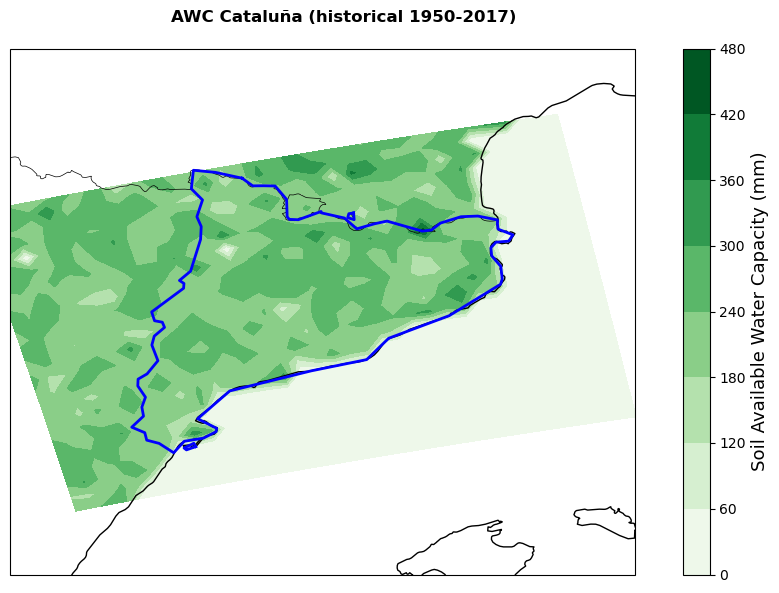

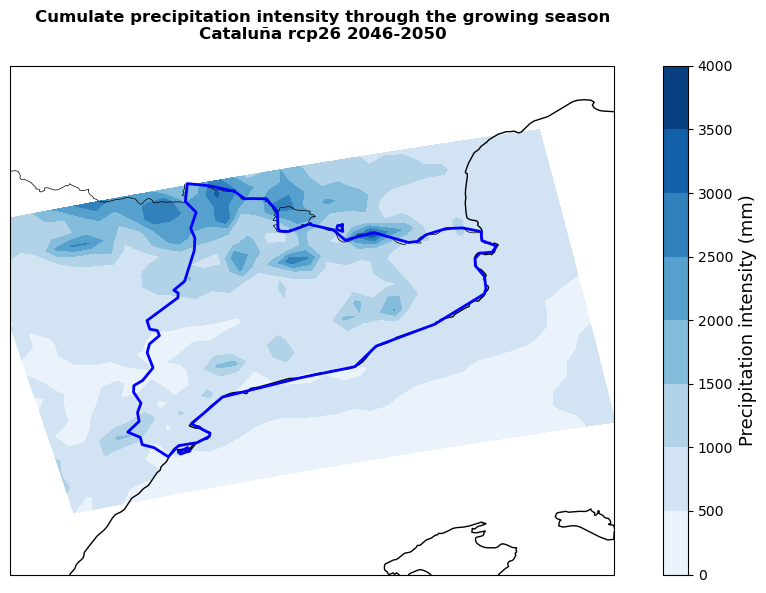

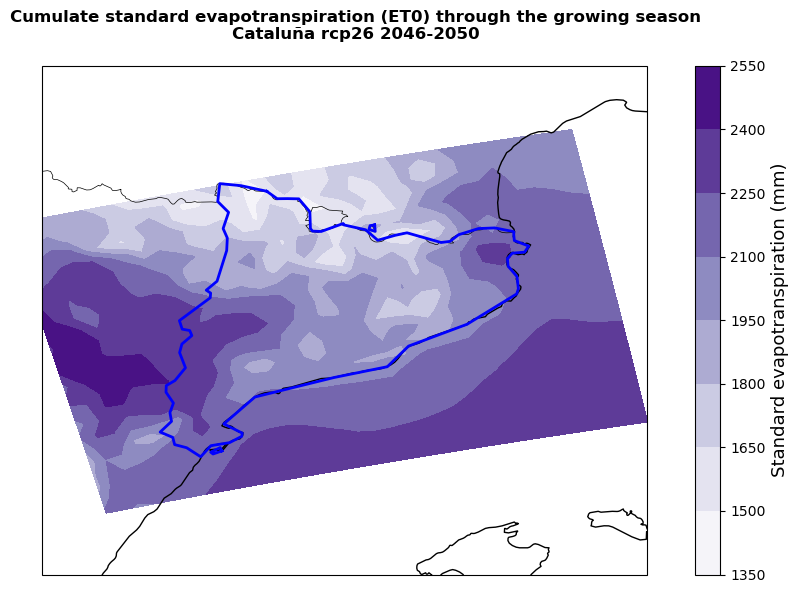

In [27]:
# Variables
rcp = ds_tasmax.attrs['experiment_id']  # Identify the climate projection
ystart = ds_tasmax['time.year'][0].to_numpy()  # Projection start year
yend = ds_tasmax['time.year'][-1].to_numpy()  # Projection end year
zoom = 0.5  # Zoom parameter

# Define longitude and latitude coordinates
lon_plot = ds_tasmax['lon'].to_numpy()
lat_plot = ds_tasmax['lat'][:].to_numpy()

# Plot soil available water capacity
plot_map(
    AWC,
    cmap='Greens',
    label='Soil Available Water Capacity (mm)',
    title=f'AWC {nuts.iloc[0,4]} (historical 1950-2017)',
    filename=f'{nuts.iloc[0,4]}_AWC.png')

# Plot cumulative precipitation through the growing season
plot_map(
    cumulative_precipitation,
    cmap='Blues',
    label='Precipitation intensity (mm)',
    title=f'Cumulate precipitation intensity through the growing season\n{nuts.iloc[0,4]} {rcp} {ystart}-{yend}',
    filename=f'{nuts.iloc[0,4]}_Precipitation.png')

# Plot cumulative ET0 through the growing season
plot_map(
    cumulative_ET0,
    cmap='Purples',
    label='Standard evapotranspiration (mm)',
    title=f'Cumulate standard evapotranspiration (ET0) through the growing season\n{nuts.iloc[0,4]} {rcp} {ystart}-{yend}',
    filename=f'{nuts.iloc[0,4]}_ET0.png')


The yield loss results for the studied region are displayed using the cell below. The resulting plot states the crop, RCP scenario and reference period used in the assessment. 

:::{tip}

Use the 'zoom' parameter to set how much you would like the final plot to be zoomed-out from the region boundaries (0=no zoom out,1=100 km). Here a zoom of 0.5 degrees (50 km) is used.
:::

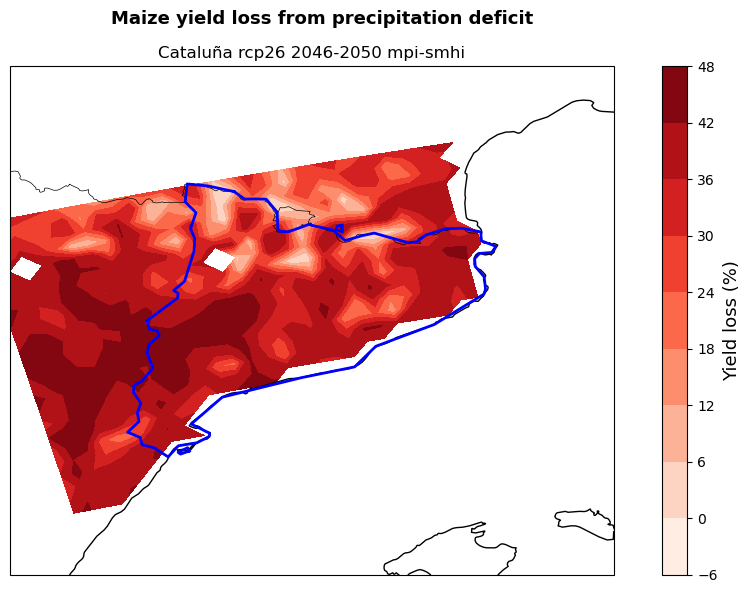

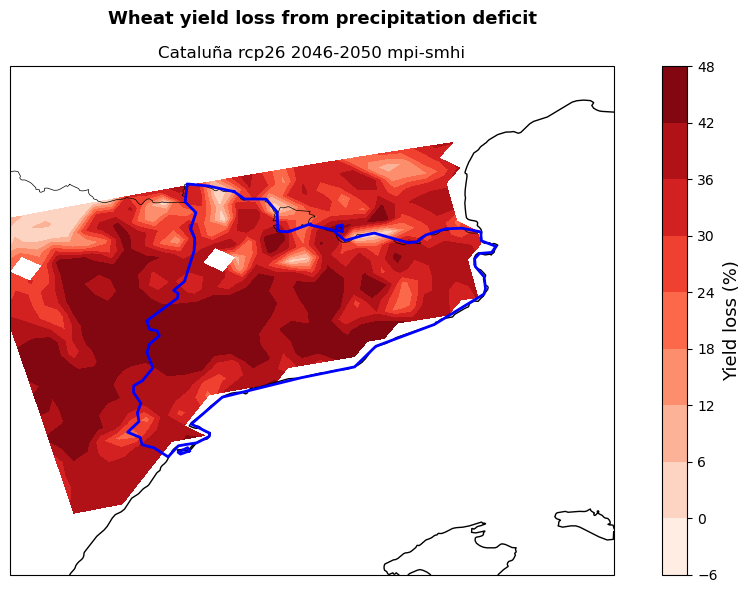

In [29]:
# Plot the yield loss for each crop
for a in np.arange(len(crop_list)):
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([bbox[0] - zoom, bbox[2] + zoom, bbox[1] - zoom, bbox[3] + zoom], crs=ccrs.PlateCarree())
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    
    # Plot yield loss
    mesh = ax.contourf(lon_plot, lat_plot, yield_loss_perc[:, :, a], cmap='Reds', transform=ccrs.PlateCarree())
    
    # Add shapefile
    sf = shapefile.Reader(f'{data_dir}/{nuts_name}')
    for shape in sf.shapes():
        x = [point[0] for point in shape.points]
        y = [point[1] for point in shape.points]
        ax.plot(x, y, transform=ccrs.PlateCarree(), color='b', linewidth=2)
    
    # Add colorbar
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label('Yield loss (%)', fontsize=13)
    
    # Titles
    plt.suptitle(f"{crop_list[a].title()} yield loss from precipitation deficit", fontsize=13, fontweight='bold')
    plt.title(f"{nuts.iloc[0,4]} {rcp} {ystart}-{yend} {gcm[:3]}-{rcm[:4]}")
    
    # Layout and save
    plt.tight_layout()
    plt.savefig(f'{results_dir}/{nuts.iloc[0,4]}_{crop_list[a]}_yield_loss.png')
    plt.show()

The maps show the potential yield loss from irrigation deficit in the studied region for the selected crops (here maize and wheat), emission scenario (here RCP2.6), period (here 2046-2050) and models combination (here mpi and smhi). Yield loss is expressed as the percentage reduction in yield if crops are grown under rainfed only conditions rather than fully irrigated. 
<br>

These maps can be used by demonstrators to understand in which areas of their region cropland will potentially experience the highest hydro-climatic stress. This allows them to target adaptation efforts in the most affected areas favouring a cost-effective use of resources. At the same time, the map provides a snap-shot of a potential future growing season that can be used to guide cropland expansion towards areas less affected by water stress.


## Conclusions

In this workflow we learned:
- how to download and explore high-resolution climate, elevation and available water capacity data for your region.
- how to use and combine these datasets to calculate the actual evapotranspiration potential of different crops using the FAO56 methodology.
- how to derive potential yield losses of different crops without full irrigation from the actual evapotranspiration deficit. 

The yield loss results produced in this workflow have been stored in .csv and .npy formats to be explored and later used in the risk assessment workflow. The yield loss results can also be visualised in the maps saved locally.



## Contributors

Euro-Mediterranean Center on Climate Change (CMCC), Italy.

Author of the workflow: Andrea Rivosecchi

### References

- Allen, R.G., Pereira, L.S., Raes, D. & Smith, M. (1998) Crop evapotranspiration-Guidelines for computing crop water requirements-FAO Irrigation and drainage paper 56. Fao, Rome. 300 (9), D05109.
- Danielson, J.J. & Gesch, D.B. (2011) Global multi-resolution terrain elevation data 2010 (GMTED2010): U.S. Geological Survey Open-File Report 2011–1073, p.26.
- Doorenbos, J. & Kassam, A.H. (1979) Yield response to water. Irrigation and drainage paper. 33, 257.
- Hengl, T. & Gupta S. (2019). Soil available water capacity in mm derived for 5 standard layers (0-10, 10-30, 30-60, 60-100 and 100-200 cm) at 250 m resolution (v0.1). Zenodo. https://doi.org/10.5281/zenodo.2629149
- Mancosu, N., Spano, D., Orang, M., Sarreshteh, S. & Snyder, R.L. (2016) SIMETAW# - a Model for Agricultural Water Demand Planning. Water Resources Management. 30 (2), 541–557. doi:10.1007/s11269-015-1176-7.
- Steduto, P., Hsiao, T.C., Fereres, E. & Raes, D. (2012) Crop yield response to water. FAO Rome.
- Van Velthuizen, H., Huddleston, B., Fischer, G., Salvatore, M., Ataman, E., Nachtergaele, F. O., Zanetti, M., Bloise, M., Antonicelli, A., Bel, J., De Liddo, A., De Salvo, P., & Franceschini, G. (2007). Mapping biophysical factors that influence agricultural production and rural vulnerability (Issue 11). Food & Agriculture Org.
- Zotarelli, L., Dukes, M. D., Romero, C. C., Migliaccio, K. W., & Morgan, K. T. (2009). Step by step calculation of the Penman-Monteith Evapotranspiration (FAO-56 Method).


 

